<h1><center><u>Google Play Store Exploratory Data analysis and Modelling</u></center></h1> 

<h2>1.1 Description </h2>

While many public datasets (on Kaggle and the like) provide Apple App Store data, there are not many counterpart datasets available for Google Play Store apps anywhere on the web. On digging deeper, I found out that iTunes App Store page deploys a nicely indexed appendix-like structure to allow for simple and easy web scraping. On the other hand, Google Play Store uses sophisticated modern-day techniques (like dynamic page load) using JQuery making scraping more challenging.



<h2>1.2 Source </h2>

<b> Link-: </b> https://www.kaggle.com/lava18/google-play-store-apps/home

<h2>2.0 Exploratory Data Analysis </h2>

In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix


In [2]:
#Reading data frame
df_app=pd.read_csv('googleplaystore.csv')
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
print("The Google play store dataset contains %d rows and %d columns." %(df_app.shape[0],df_app.shape[1]))

The Google play store dataset contains 10841 rows and 13 columns.


<h2>2.1 Dropping Missing Values and Duplicates from data </h2>

In [4]:
#Dropping Data frame which has NAN values
df_app=df_app.dropna()
print("The Google play store dataset contains %d rows and %d columns after dropping NAN." %(df_app.shape[0],df_app.shape[1]))

The Google play store dataset contains 9360 rows and 13 columns after dropping NAN.


In [5]:
#Checking if there are any duplicates rows present in dataset that has same App
# False= No duplicate
# True=Duplicate
df_app.duplicated(subset='App').value_counts()

False    8190
True     1170
dtype: int64

In [6]:
#Dropping the duplicates
df_app=df_app.drop_duplicates(subset='App')

In [7]:
print("The Google play store dataset contains %d rows and %d columns after dropping NAN and duplicates." %(df_app.shape[0],df_app.shape[1]))

The Google play store dataset contains 8190 rows and 13 columns after dropping NAN and duplicates.


<h2> 2.2 Data Pre-processing </h2>

In [8]:
#Checking the data types of dataset
df_app.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Since the columns 'Installs','Price' are string we convert them into integer and float format respectively.

In [9]:
#Converting the Installs column into integer
df_app['Installs']=df_app['Installs'].apply(lambda a:a.split('+')[0])   #Removes '+' from Installs
se=df_app['Installs'].apply(lambda a:a.split(','))                      #Removes ',' from Installs 

def add_list(x):
    sum=' '
    for i in range(0,len(x)):
        sum+=x[i]
    return int(sum)  

df_app['Installs']=se.apply(lambda a:add_list(a))                      #Convert str to int values 
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [10]:
#Removing Currency symbol from the Price and making it float
def remove_curr(x):
    if x !='0':
        x=x.split('$')[1]
    return float(x)   

df_app['Price']=df_app['Price'].apply(lambda a:remove_curr(a))  #Removes '$' from Price
df_app.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


<h2> 2.3.0 Plotting </h2>

In [11]:
#Checking the number of apps that available based on type: Free v/s Paid
df_app['Type'].value_counts()

Free    7588
Paid     602
Name: Type, dtype: int64

<h3> 2.3.1 Total Number of Apps available and are installed </h3> 

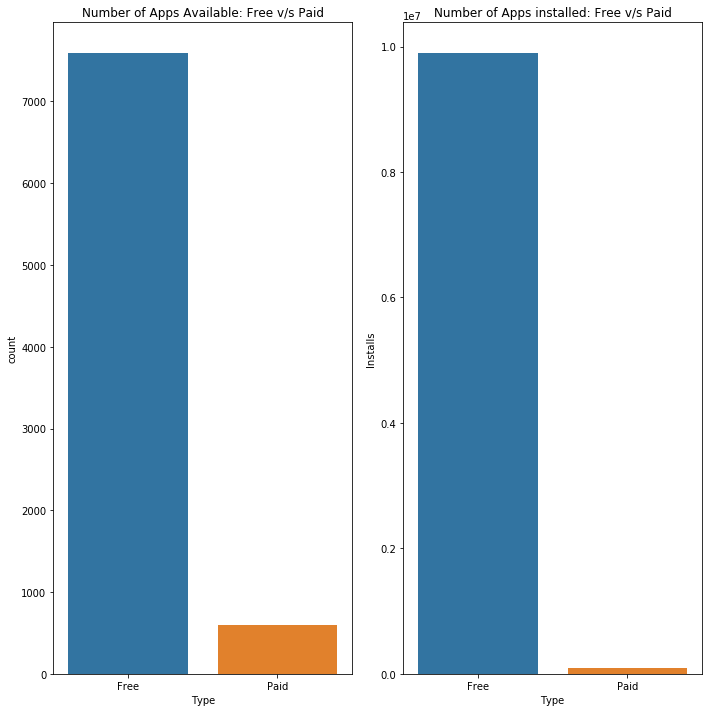

In [12]:
#Number of free and paid Apps available
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sns.countplot(x='Type',data=df_app)
plt.title("Number of Apps Available: Free v/s Paid")

#Most installed apps based on Category
plt.subplot(1,2,2)
sns.barplot(x='Type',y='Installs',data=df_app,ci=None)
plt.title("Number of Apps installed: Free v/s Paid")
plt.tight_layout()

<h3> 2.3.2 Number of Apps available based on Catgeory </h3>

Text(0.5, 1.0, 'Number of Apps available based on Category')

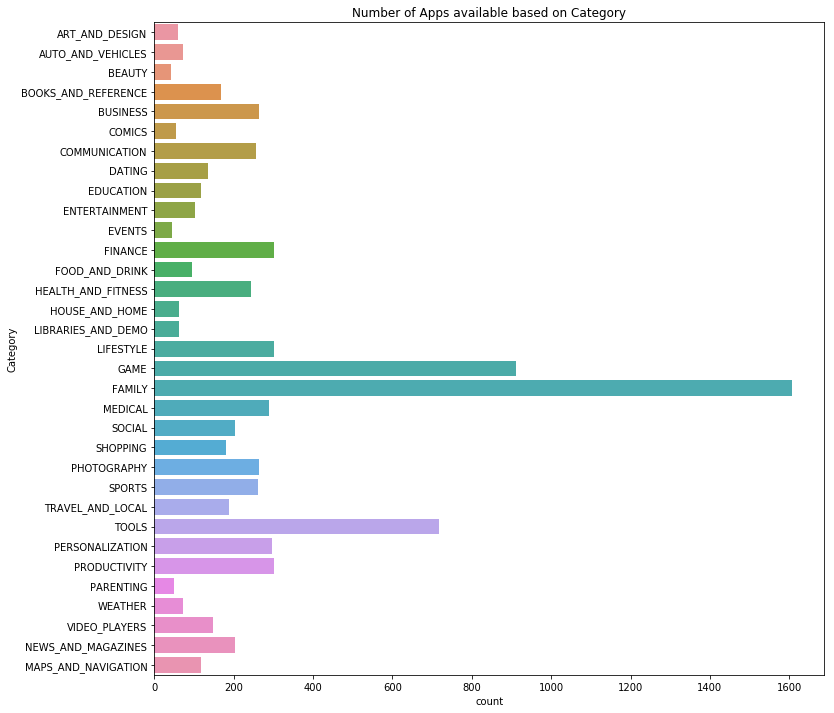

In [13]:
#Checking the number of Apps available on playstore based on category
plt.figure(figsize=(12,12))
sns.countplot(y='Category',data=df_app)
plt.title("Number of Apps available based on Category")

<h3> 2.3.3 Number of Apps installed based on Category </h3>

Text(0.5, 1.0, 'Number of Apps installed based on Category')

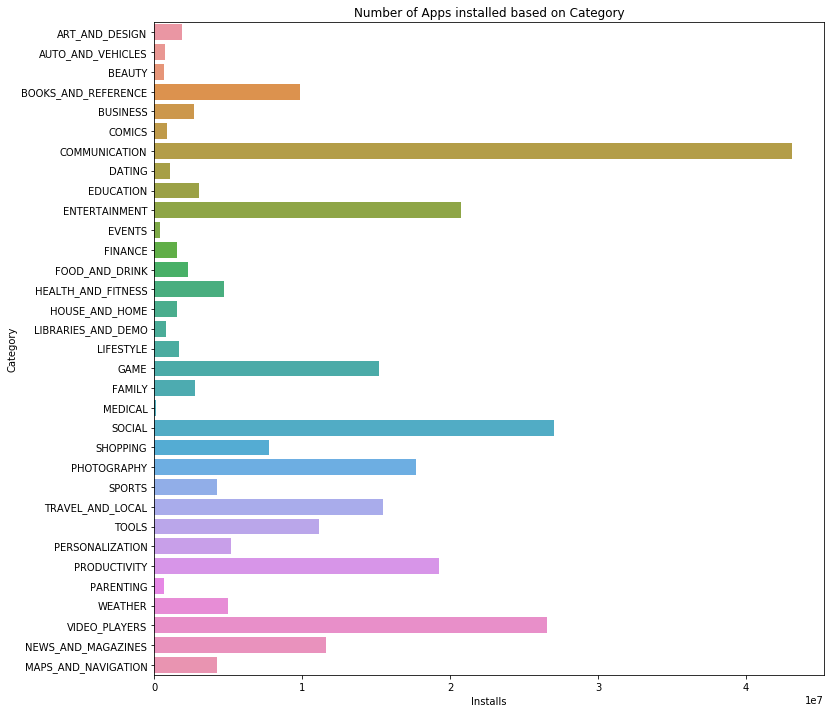

In [14]:
#Most installed apps based on Category
plt.figure(figsize=(12,12))
sns.barplot(x='Installs',y='Category',data=df_app,ci=None)
plt.title("Number of Apps installed based on Category")

<h3> 2.3.4 Number of Apps available based on Content rating </h3>

Text(0.5, 1.0, 'Number of Apps available based on Content rating')

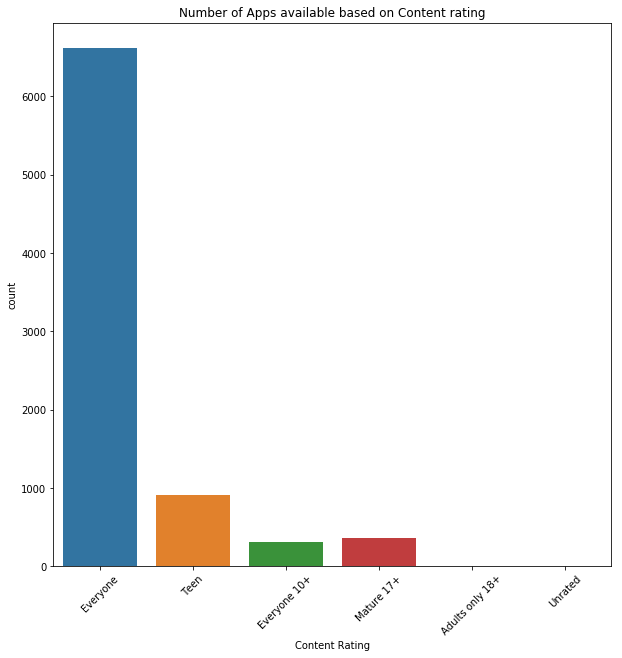

In [15]:
#Apps available based on Content rating
plt.figure(figsize=(10,10))
sns.countplot(x='Content Rating',data=df_app,)
plt.xticks(rotation=45)
plt.title("Number of Apps available based on Content rating")

<h3> 2.3.5 Number of Apps installed based on Content rating </h3>

Text(0.5, 1.0, 'Number of Apps installed based on Content rating')

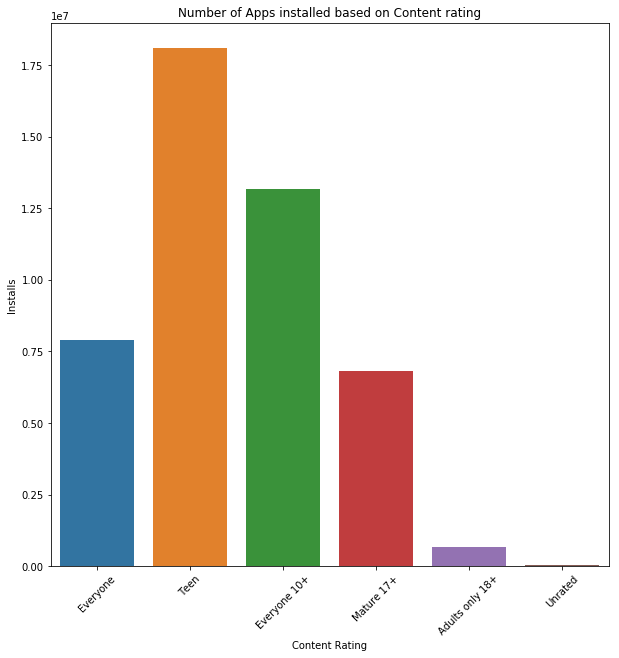

In [16]:
#Apps installed based on Content rating
plt.figure(figsize=(10,10))
sns.barplot(x='Content Rating',y='Installs',data=df_app,ci=None)
plt.xticks(rotation=45)
plt.title("Number of Apps installed based on Content rating")

<h3>2.3.6 Android Versions available for most apps </h3>

Text(0.5, 1.0, "Android Version's available")

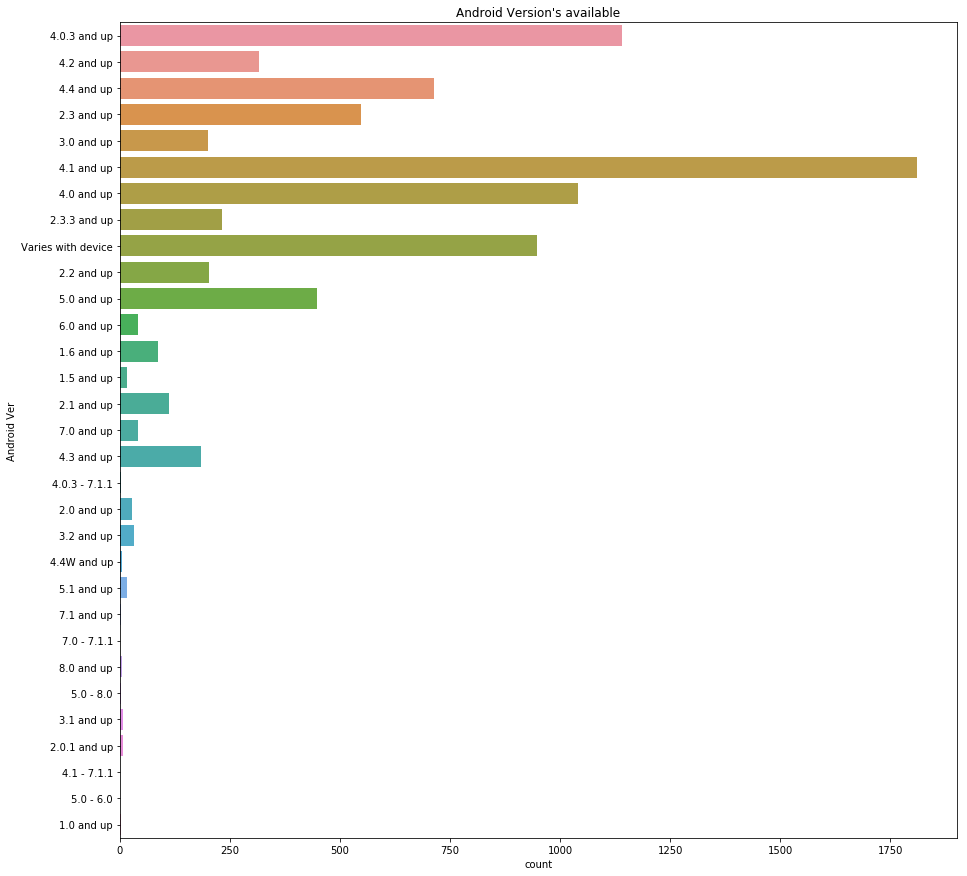

In [17]:
#Android Version of the most available apps
plt.figure(figsize=(15,15))
sns.countplot(y='Android Ver',data=df_app)
plt.title("Android Version's available")

<h3> 2.3.7 Android Versions of installed Apps </h3>

Text(0.5, 1.0, 'Android Versions of installed Apps')

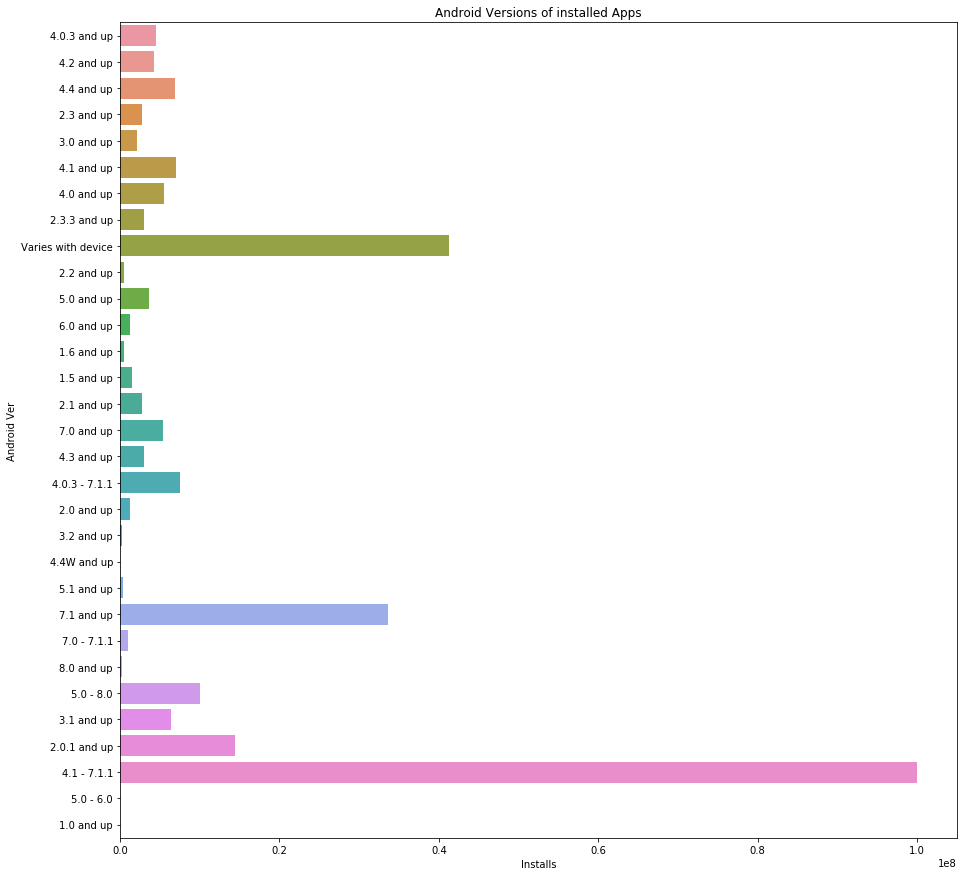

In [18]:
#Android  version of most installed apps
plt.figure(figsize=(15,15))
sns.barplot(x='Installs',y='Android Ver',data=df_app,ci=None)
plt.title("Android Versions of installed Apps")

<h3> 2.3.8 Ratings of Apps v/s Number of installed </h3>

Text(0.5, 1.0, 'Number of Apps and ratings ')

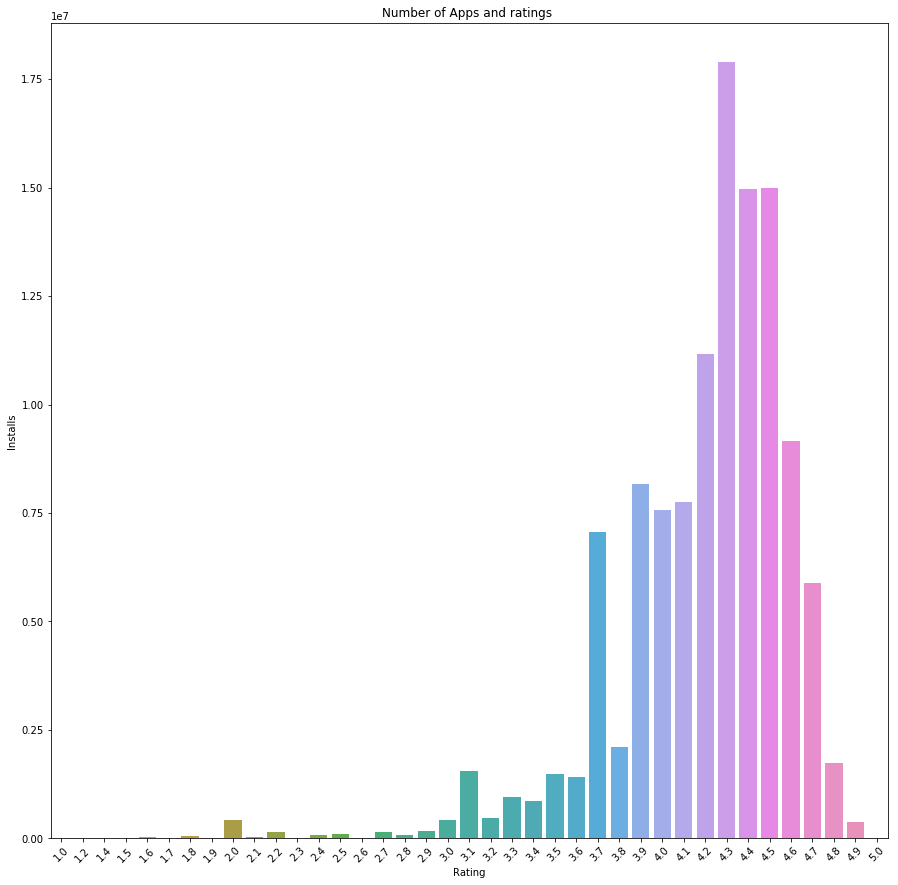

In [19]:
#Ratings of Apps and the number of installed
plt.figure(figsize=(15,15))
sns.barplot(y='Installs',x='Rating',data=df_app,ci=None)
plt.xticks(rotation=45)
plt.title("Number of Apps and ratings ")

<h3>2.3.9 Top 20 Most downloaded Paid Apps </h3>

In [20]:
#Most download  Paid apps
df_type=df_app[df_app['Type']=='Paid']
df_type.sort_values(by='Installs',ascending=False)['App'].head(20)

2241                                             Minecraft
4034                                         Hitman Sniper
9165     League of Stickman 2018- Ninja Arena PVP(Dream...
2242                            Card Wars - Adventure Time
9151                               Lost Journey (Dreamsky)
3405                                            HD Widgets
3403                                 Beautiful Widgets Pro
5631                               Five Nights at Freddy's
6675                                  Infinity Dungeon VIP
5578                               Sleep as Android Unlock
5490                                            True Skate
2883                                   Facetune - For Free
9941                                                Tasker
4260                                     Cut the Rope GOLD
8860                                           Bloons TD 5
8804                                   DraStic DS Emulator
7355                                               Three

<h2> 3.0 Top 3 most common category of Apps that are installed </h2> <br>
        1. Communication  
        2. Social  
        3. Video Players 

<h3> 3.1 Top 20 apps that are most installed bases on category Communication </h3>

In [21]:
#Top 20 apps that are installed most in Category Communication
df_com=df_app[df_app['Category']=='COMMUNICATION']
df_com.sort_values(by='Installs',ascending=False)['App'].head(20)

335              Messenger – Text and Video Chat for Free
391                         Skype - free IM & video calls
338                          Google Chrome: Fast & Secure
340                                                 Gmail
341                                              Hangouts
336                                    WhatsApp Messenger
347                         imo free video calls and chat
378           UC Browser - Fast Download Private & Secure
371                 Google Duo - High Quality Video Calls
403                           LINE: Free Calls & Messages
342                                       Viber Messenger
345                           Yahoo Mail – Stay Organized
449     Truecaller: Caller ID, SMS spam blocking & Dialer
4279                                                  Kik
406                           BBM - Free Calls & Messages
407                          KakaoTalk: Free Calls & Text
395            GO SMS Pro - Messenger, Free Themes, Emoji
339           

<h3>3.2 Top 20 Apps that are most installed based on category Social </h3>

In [22]:
#Top 20 apps that are installed most in Category Social
df_soc=df_app[df_app['Category']=='SOCIAL']
df_soc.sort_values(by='Installs',ascending=False)['App'].head(20)

2544                                  Facebook
2554                                   Google+
2545                                 Instagram
2546                             Facebook Lite
2550                                  Snapchat
2588            Badoo - Free Chat & Dating App
2582                                  LinkedIn
6373                                        VK
2592              Tango - Live Video Broadcast
3951                   BIGO LIVE - Live Stream
3945            Tik Tok - including musical.ly
2552                                 Pinterest
2548                                    Tumblr
2595    ooVoo Video Calls, Messaging & Stories
2593            MeetMe: Chat & Meet New People
2636                   Zello PTT Walkie Talkie
2629                       POF Free Dating App
2614               SKOUT - Meet, Chat, Go Live
2580                        Kate Mobile for VK
2578                    Periscope - Live Video
Name: App, dtype: object

<h3>3.3 Top 20 Apps that are most installed based on category Video player </h3>

In [23]:
#Top 20 apps that are installed most in Category Video Player
df_vp=df_app[df_app['Category']=='VIDEO_PLAYERS']
df_vp.sort_values(by='Installs',ascending=False)['App'].head(20)

3665                                              YouTube
3687                              Google Play Movies & TV
3703                                            MX Player
3672                                     Motorola Gallery
3675                                      VLC for Android
4032                                             Dubsmash
4688               VivaVideo - Video Editor & Photo Movie
3670                                    Motorola FM Radio
4696    VideoShow-Video Editor, Video Maker, Beauty Ca...
4038    DU Recorder – Screen Recorder, Video Editor, Live
3686                                           Vigo Video
3690          MiniMovie - Free Video and Slideshow Editor
3691                                Samsung Video Library
3693                 LIKE – Magic Video Maker & Community
4049                        KineMaster – Pro Video Editor
3677                                             Vote for
5612                                            Ringdroid
4685          

<h2> 4.0 Machine Learning Modelling </h2>

In [24]:
#Reading CSV file that contains reviews for Apps
df=pd.read_csv('googleplaystore_user_reviews.csv')
df.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000
6,10 Best Foods for You,Amazing,Positive,0.60,0.900000
7,10 Best Foods for You,NaN,NaN,NaN,NaN
8,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000
9,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000


In [25]:
#Size of data frame
df.shape

(64295, 5)

In [26]:
#Class labels available
df['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

<h3> 4.1 Reviews Pre-Processing </h3>

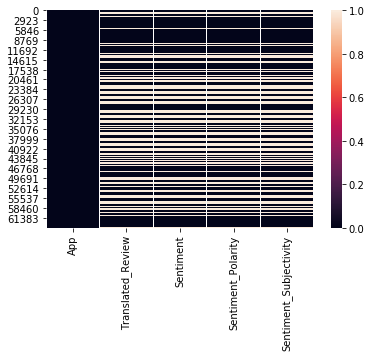

In [27]:
#Checking if there are any missing values
sns.heatmap(df.isna())

In [28]:
#Dropping the missing values from the data frame
df=df.dropna()
df.shape

(37427, 5)

In [29]:
#Reviews and Labels
reviews=df['Translated_Review']
labels=df['Sentiment']

In [30]:
# User-defined function
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned


In [31]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
#Stop words and Lemmatizer
Stop=set(stopwords.words('english'))
WrdLem=WordNetLemmatizer()
print(Stop)

{"it's", "you've", 'until', 'wasn', 'him', 'through', 'has', 'doing', 'because', 'no', 'is', "you'd", 've', "hasn't", 'am', 'while', 'further', 'what', 'just', 'mustn', "mustn't", 'herself', 'hadn', 'have', 'if', 'to', 'shan', 'those', 'why', "weren't", 'did', 'she', 'same', 'how', 'too', "aren't", 'y', 'that', 'isn', "don't", 'll', 'couldn', 'with', 'be', 'ma', 'who', "shouldn't", 'themselves', 'only', 'when', 'they', 'was', 'shouldn', 'our', 'about', 'should', 'hasn', 'her', 'm', 'for', 'myself', 'in', 'against', 'my', 'his', 'down', 'don', 'didn', 'into', 'been', 'having', 'out', 'i', "didn't", 'between', "doesn't", 'will', "isn't", 'needn', 'the', 'each', 'there', 'above', 'ain', 'before', 'do', 'hers', "wasn't", "wouldn't", 'me', 'yourselves', 'under', 'its', 'weren', "needn't", 'this', 's', 'an', 'it', 'yours', 'other', 'or', "you're", 'are', 'a', 'than', 'ourselves', 'were', 'then', "haven't", "mightn't", 'aren', 'whom', 'where', 'own', "you'll", 'very', 'and', "should've", 'mor

In [33]:
#Cleaning the reviews(removing html tags,punctuation,Lemmatizations)
Cleaned_sent=[]
for sent in reviews:
    r1=[]
    sent=cleanhtml(sent)
    sent=cleanpunc(sent)
    sent=sent.lower()
    for  word in sent.split():
        if ((word.isalpha()) & (len(word)>2)):
            if word not in Stop:
                w=WrdLem.lemmatize(word)
                r1.append(w)
            else:
                continue
        else:
            continue
    str1 = (" ".join(r1))        
     
    Cleaned_sent.append(str1)

df['Cleaned_text']=Cleaned_sent
df.head(5)    

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Cleaned_text
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,like eat delicious food thats cooking food cas...
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,help eating healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,work great especially going grocery store
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,best idea
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,best way


In [34]:
#Defining some user defined function

def plot_cm_rates(y_test, Y_pred):

    #Plotting Confusion matrix
    x=confusion_matrix(y_test,Y_pred)
    cm_df=pd.DataFrame(x,index=['Negative','Neutral','Positive'],columns=['Negative','Neutral','Positive'])

    sns.set(font_scale=1,color_codes=True,palette='deep')
    sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt='d',cmap="YlGnBu")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix ")


def plot_miss_error(cv_scores,hyperparam):
    
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = hyperparam[MSE.index(min(MSE))]
    print('\nThe optimal value of hyper parameter is %f.' % optimal_k)
    
    # plot misclassification error vs K 
    plt.figure(figsize=(8,8))
    plt.plot(hyperparam, MSE)

    for xy in zip(hyperparam, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Values of Hyperparameter')
    plt.ylabel('Misclassification Error')
    plt.title("Missclassification error v/s Hyperparameter")
    plt.show()
    
    return optimal_k


def train_test_accuracy(Classifier,X_train,y_train,X_test,y_test):
    
    #Train Model Fitting
    Classifier.fit(X_train,y_train)
    pred_train = Classifier.predict(X_train)
    
    #Train Accuracy
    train_acc = accuracy_score(y_train, pred_train, normalize=True) * float(100)
    
    #Test Accuracy
    pred_test = Classifier.predict(X_test)
    test_acc = accuracy_score(y_test, pred_test, normalize=True) * float(100)
    
    #Printing train and test accuracy
    print('\n****Train accuracy = %f%%' % (train_acc))
    print('\n****Test accuracy =  %f%%' % (test_acc))
    
    #plotting Confusion matrix
    plot_cm_rates(y_test,pred_test)

<h3> 4.2 Splitting the data into train and test split </h3>

In [35]:
#Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(df['Cleaned_text'].values,labels,test_size=0.3,random_state=0)

In [36]:
#Size of training and test data
print("The number of data points used in  training model is %d "%(X_train.shape[0]))
print("The number of data points used in testing model is %d" %(X_test.shape[0]))

The number of data points used in  training model is 26198 
The number of data points used in testing model is 11229


<h3>4.4.0 Bag of Words (Converting text into vectors) </h3>

In [37]:
#Train Vector
bow=CountVectorizer()
X_train_bow=bow.fit_transform(X_train)

#Test vector
X_test_bow=bow.transform(X_test)

<h3> 4.4.1 Logistic Regression </h3>

In [38]:
#Hyper-Parameter 
C=[10**-4,10**-2,10**0,10**2,10**4]

In [39]:
#Hyper Parameter tunning
cv_scores=[]
for c in C:
    LR=OneVsRestClassifier(LogisticRegression(C=c,penalty='l1'))
    scores=cross_val_score(LR,X_train_bow,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


The optimal value of hyper parameter is 1.000000.


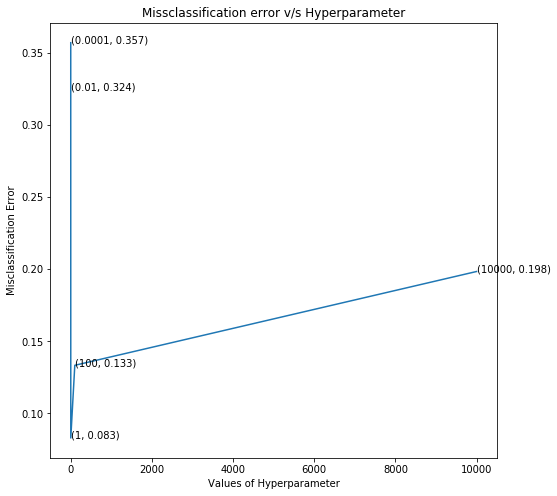

In [40]:
#Plotting Misclassification error
optimal=plot_miss_error(cv_scores,C)

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



****Train accuracy = 95.988243%

****Test accuracy =  93.026984%


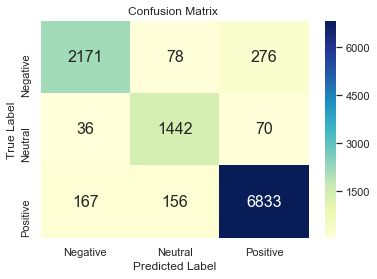

In [41]:
#Model Fitting based on  optimal value and Plotting Confusion Matrix
classifier1=OneVsRestClassifier(LogisticRegression(C=optimal,penalty='l1'))

train_test_accuracy(classifier1,X_train_bow,y_train,X_test_bow,y_test)

<h3> 4.4.2 Linear SVM </h3>

In [42]:
#Hyper Parameter
alpha=[10**-x for x in range(-5,3)]

In [43]:
#Hyper parameter tunning
cv_scores=[]
for a in alpha:
    lsvc=LinearSVC(C=a)
    scores=cross_val_score(lsvc,X_train_bow,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 


The optimal value of hyper parameter is 0.100000.


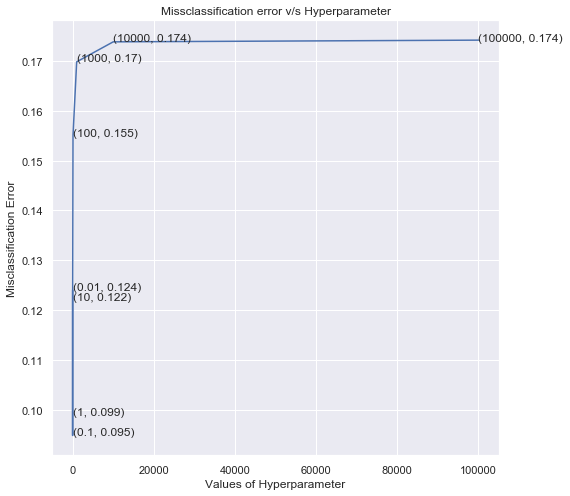

In [44]:
#Plotting misclassification error
optimal=plot_miss_error(cv_scores,alpha)


****Train accuracy = 96.831819%

****Test accuracy =  91.762401%


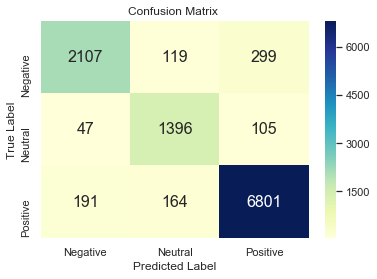

In [45]:
#Model Fitting based on  optimal value and plotting confusion matrix
classifier1=LinearSVC(C=optimal)

train_test_accuracy(classifier1,X_train_bow,y_train,X_test_bow,y_test)

<h3> 4.4.3 XGB Classifier </h3>

In [46]:
#Hyper parameter 
lr=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [47]:
#Hyper paramete tunning
cv_scores=[]
for l in lr:
    XGB=XGBClassifier(learning_rate=l)
    scores=cross_val_score(XGB,X_train_bow,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    


The optimal value of hyper parameter is 1.000000.


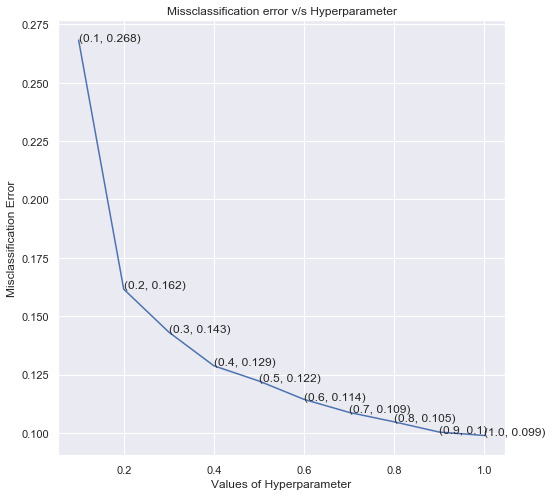

In [48]:
#Plotting misclassification error
optimal=plot_miss_error(cv_scores,lr)


****Train accuracy = 93.117795%

****Test accuracy =  91.094487%


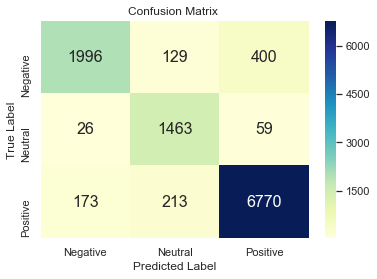

In [49]:
#Model Fitting based on  optimal value and plotting the confusion matrix
classifier1=XGBClassifier(learning_rate=optimal)
train_test_accuracy(classifier1,X_train_bow,y_train,X_test_bow,y_test)

<h3> 4.5.0 TF-IDF (Converting text to vectors) </h3>

In [50]:
#Train vector
tfidf=TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)

#Test Vector
X_test_tfidf=tfidf.transform(X_test)

<h3> 4.5.1 Logistic Regression </h3>

In [51]:
#Hyper Parameter tunning
cv_scores=[]
for c in C:
    LR=OneVsRestClassifier(LogisticRegression(C=c,penalty='l1'))
    scores=cross_val_score(LR,X_train_tfidf,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


The optimal value of hyper parameter is 1.000000.


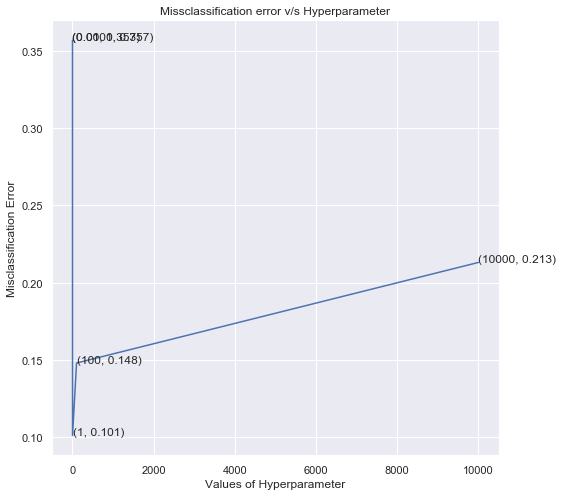

In [52]:
#Plotting misclassification error
optimal=plot_miss_error(cv_scores,C)

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



****Train accuracy = 92.709367%

****Test accuracy =  91.423991%


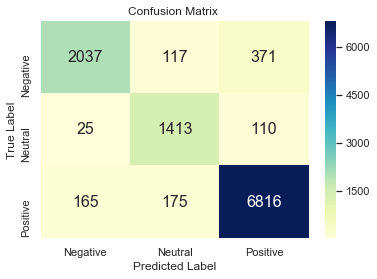

In [53]:
#Model Fitting based on  optimal value and Confusion matrix
classifier1=OneVsRestClassifier(LogisticRegression(C=optimal,penalty='l1'))

train_test_accuracy(classifier1,X_train_tfidf,y_train,X_test_tfidf,y_test)

<h3> 4.5.2 Linear SVM </h3>

In [54]:
#Hyper Parameter tunning
cv_scores=[]
for a in alpha:
    lsvc=LinearSVC(C=a)
    scores=cross_val_score(lsvc,X_train_tfidf,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 


The optimal value of hyper parameter is 1.000000.


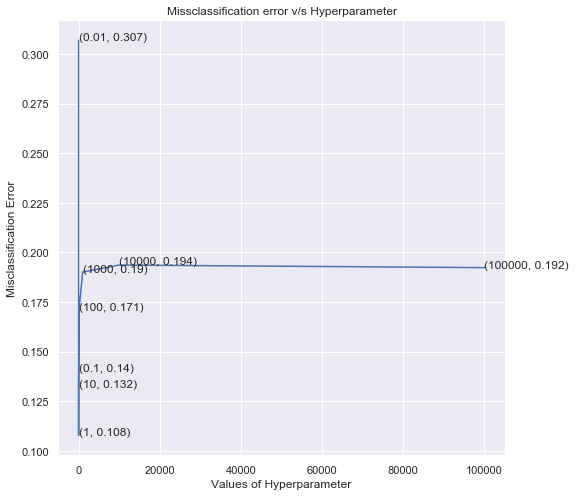

In [55]:
#Plotting misclassification error
optimal=plot_miss_error(cv_scores,alpha)


****Train accuracy = 97.495992%

****Test accuracy =  90.488913%


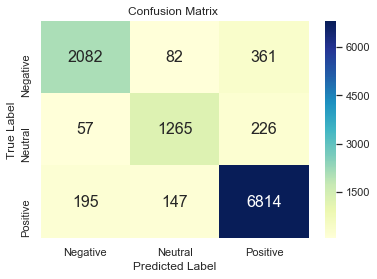

In [56]:
#Model Fitting based on  optimal value and Confusion Matrix
classifier1=LinearSVC(C=optimal)

train_test_accuracy(classifier1,X_train_tfidf,y_train,X_test_tfidf,y_test)

<h3> 4.5.3 XGB Classifier </h3>

In [57]:
#Hyper parameter
cv_scores=[]
for l in lr:
    XGB=XGBClassifier(learning_rate=l)
    scores=cross_val_score(XGB,X_train_tfidf,y_train,cv=3,scoring='accuracy')
    cv_scores.append(scores.mean())
    


The optimal value of hyper parameter is 1.000000.


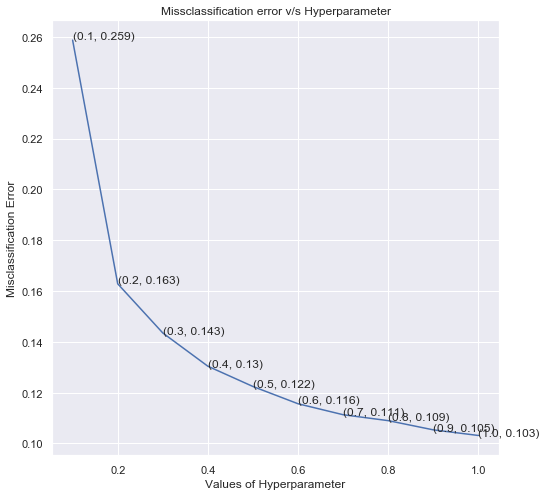

In [58]:
#Plotting misclassification error
optimal=plot_miss_error(cv_scores,lr)


****Train accuracy = 93.888846%

****Test accuracy =  90.791700%


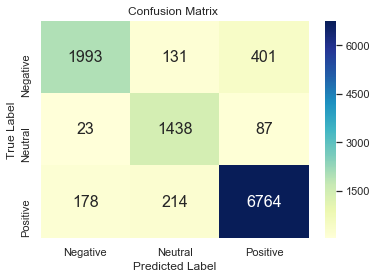

In [59]:
#Model Fitting based on  optimal value and Confusion Matrix
classifier1=XGBClassifier(learning_rate=optimal)

train_test_accuracy(classifier1,X_train_tfidf,y_train,X_test_tfidf,y_test)

<h2> 5.0 Conclusion: </h2>

* Exploratory data analyis of the Google play store data was done.
* Top Apps that are most downloaded is found out.
* Machine Learning models are applied to the reviews of the App's to predict whether given review is Positive,Neutral or Negative.
* Also hyper parameter tuning of the model was also done to find the best parameter. The details of it is shown below.

<h3> With Bag of Words represetation </h3>

<table style="width:75%">
  <tr>
    <th>Model</th>
    <th>Hyperparameter</th> 
    <th>Train Accuracy(%)</th> 
    <th>Test Accuracy(%)</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>C=1</td> 
    <td>95.99</td> 
    <td>93.02</td>
  </tr>
  <tr>
    <td>Linear SVM</td>
    <td>C=0.1</td> 
    <td>96.83</td>
    <td>91.76</td>
  </tr>
  <tr>
    <td>XGB Classifier</td>
    <td>learning_rate=1</td> 
    <td>93.11</td>
    <td>91.09</td>
  </tr>
</table>

<h3> With TF-IDF representation </h3>

<table style="width:75%">
  <tr>
    <th>Model</th>
    <th>Hyperparameter</th> 
    <th>Train Accuracy(%)</th> 
    <th>Test Accuracy(%)</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>C=1</td> 
    <td>92.70</td> 
    <td>91.42</td>
  </tr>
  <tr>
    <td>Linear SVM</td>
    <td>C=1</td> 
    <td>97.49</td>
    <td>90.48</td>
  </tr>
  <tr>
    <td>XGB Classifier</td>
    <td>learning_rate=1</td> 
    <td>93.88</td>
    <td>90.79</td>
  </tr>
</table>